<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 2
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

## Import packages needed 

In [ ]:
# Helper libraries
import datetime
from packaging import version
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from collections import Counter
import numpy as np
import pandas as pd

# TensorFlow and tf.keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from keras.layers import BatchNormalization
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.4.1


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.4.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Mount Google Drive to Colab Enviorment

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [ ]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [ ]:
print('train_images:\t{}'.format(train_images.shape))
print('train_labels:\t{}'.format(train_labels.shape))
print('test_images:\t\t{}'.format(test_images.shape))
print('test_labels:\t\t{}'.format(test_labels.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


### Review labels for training dataset

In [ ]:
print("First ten labels training dataset:\n {}\n".format(train_labels[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


### Plot Examples

In [ ]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
x_preview, y_preview = get_three_classes(x_train, y_train)
x_preview, y_preview = get_three_classes(x_test, y_test)

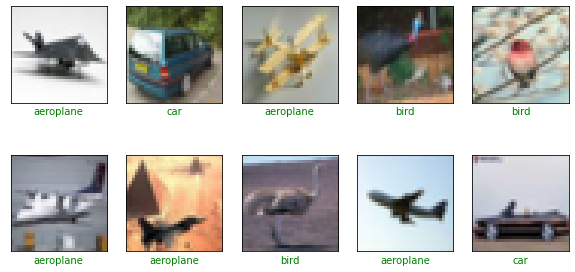

In [ ]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

### Random Review of Examples 

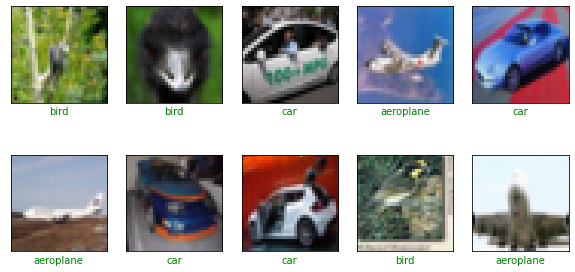

In [ ]:
show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class  the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [ ]:
class_names = [['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']]

### Preprocessing the Examples
 The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255.
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [ ]:
train_images_norm = train_images.astype('float32')/255.
test_images_norm = test_images.astype('float32')/255.

In [ ]:
train_images_norm.shape, test_images_norm.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

## Validating our approach

10,000 samples of our training data to use as a validation set. 

In [ ]:
val_images_norm, train_images_norm = train_images_norm[:10000], train_images_norm[10000:] 
val_labels, train_labels = train_labels[:10000], train_labels[10000:]

In [ ]:
val_images_norm.shape, val_labels.shape

((10000, 32, 32, 3), (10000, 1))

In [ ]:
train_images_norm.shape, train_labels.shape

((40000, 32, 32, 3), (40000, 1))

## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


### Build CNN Model

We use a Sequential class defined in Keras to create our model. The first 4 layers Conv2D and MaxPooling handle feature learning.  The last 3 layers, handle classification.  

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2),strides=2))
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 512)       1180160   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 512)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 1024)        4719616   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

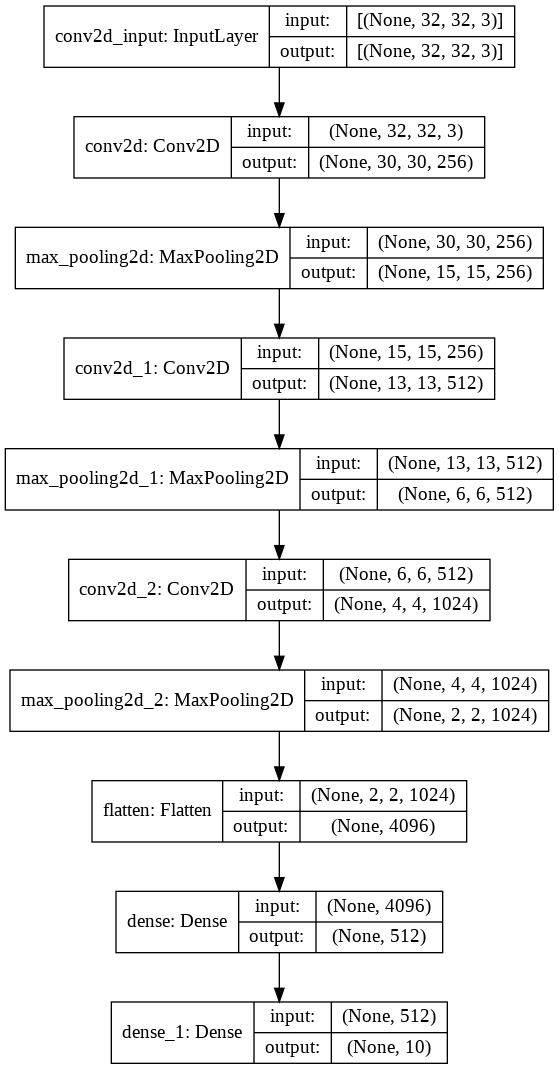

In [ ]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

### Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Training the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
history = model.fit(train_images_norm
                    ,train_labels
                    ,epochs=200
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
79/79 [==============================] - 205s 3s/step - loss: 2.0390 - accuracy: 0.2322 - val_loss: 1.4777 - val_accuracy: 0.4496
Epoch 2/200
79/79 [==============================] - 201s 3s/step - loss: 1.3856 - accuracy: 0.5015 - val_loss: 1.1671 - val_accuracy: 0.5860
Epoch 3/200
79/79 [==============================] - 198s 3s/step - loss: 1.1210 - accuracy: 0.6007 - val_loss: 1.1958 - val_accuracy: 0.5875
Epoch 4/200
79/79 [==============================] - 202s 3s/step - loss: 1.0028 - accuracy: 0.6512 - val_loss: 1.0028 - val_accuracy: 0.6599
Epoch 5/200
79/79 [==============================] - 198s 3s/step - loss: 0.8481 - accuracy: 0.7045 - val_loss: 0.9450 - val_accuracy: 0.6769
Epoch 6/200
79/79 [==============================] - 194s 2s/step - loss: 0.7471 - accuracy: 0.7454 - val_loss: 0.8935 - val_accuracy: 0.6932
Epoch 7/200
79/79 [==============================] - 196s 2s/step - loss: 0.6428 - accuracy: 0.7802 - val_loss: 0.8028 - val_accuracy: 0.7265
Epoch 

### Validation Data
Data on which to evaluate the loss and any model metrics at the end of each epoch<br>
The model will not be trained on this data

## Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [ ]:
loss, accuracy = model.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 8s 26ms/step - loss: 1.0362 - accuracy: 0.7342
test set accuracy:  73.42000007629395


## Predictions

In [ ]:
preds = model.predict(test_images_norm)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


## Plotting Performance Metrics 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
8,0.454523,0.844275,0.858132,0.7146
9,0.376798,0.871675,0.807743,0.7358
10,0.301494,0.896750,0.837559,0.7440
11,0.214431,0.929200,0.923338,0.7355
12,0.174914,0.942950,1.009535,0.7409


In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

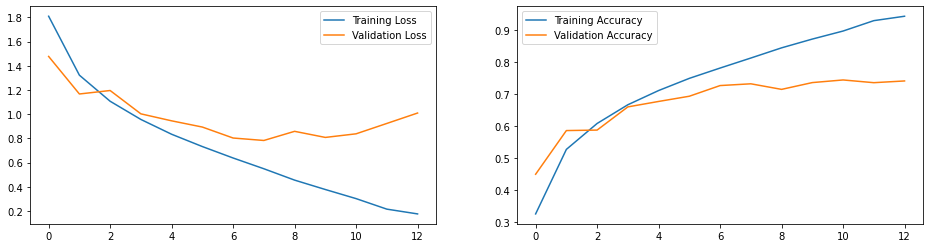

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Creating confusion matrices

Let us see what the confusion matrix looks like. Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

Get the predicted classes

In [ ]:
pred_classes = np.argmax(model.predict(train_images_norm), axis=-1)
pred_classes

array([1, 6, 6, ..., 9, 1, 1])

### Visualizing the confusion matrix

In [ ]:
conf_mx = tf.math.confusion_matrix(train_labels, pred_classes)
conf_mx

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[3944,    0,    0,    4,    3,    2,    3,    4,   33,    2],
       [  10, 3953,    0,    5,    3,    6,    6,    1,   41,    1],
       [ 145,    1, 3143,  120,  293,  125,   59,   42,   38,    2],
       [   7,    1,    0, 3782,   31,  118,   21,    6,   18,    0],
       [  14,    1,    1,   13, 3932,   20,    4,    4,   11,    1],
       [   1,    0,    0,   48,   38, 3956,    5,    6,    9,    0],
       [   5,    1,    2,   30,   22,   18, 3883,    0,    9,    0],
       [   0,    0,    0,   10,   28,   15,    1, 3945,    0,    0],
       [  26,    0,    0,    4,    0,    3,    0,    2, 3937,    3],
       [  42,   28,    1,   14,    2,   13,   11,    8,   44, 3856]],
      dtype=int32)>

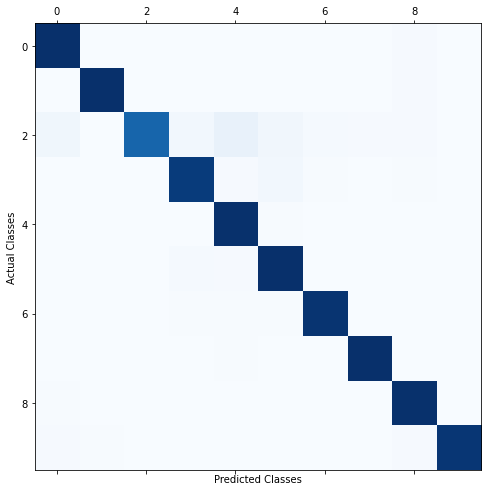

In [ ]:
plt.figure(figsize=(16,8))
plt.matshow(conf_mx, cmap=plt.cm.Blues,fignum=1)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()

### Load HDF5 Model Format 

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/model_0.7440.h5')

In [ ]:
preds = model.predict(test_images_norm)

In [ ]:
preds.shape

(10000, 10)

In [ ]:
print("The first predictions\n {}\n".format(preds[0]))

The first predictions
 [0.002 0.    0.001 0.909 0.    0.083 0.002 0.    0.002 0.   ]



In [ ]:
print(class_names)

[['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']]


In [ ]:
print("First ten entries of the predictions:\n {}\n".format(preds[0:20]))

First ten entries of the predictions:
 [[0.002 0.    0.001 0.909 0.    0.083 0.002 0.    0.002 0.   ]
 [0.    0.001 0.    0.    0.    0.    0.    0.    0.999 0.   ]
 [0.096 0.012 0.    0.    0.    0.001 0.    0.002 0.842 0.047]
 [0.988 0.001 0.002 0.007 0.    0.    0.    0.    0.001 0.   ]
 [0.    0.    0.004 0.01  0.835 0.001 0.15  0.    0.    0.   ]
 [0.    0.    0.    0.006 0.    0.005 0.988 0.    0.    0.   ]
 [0.    0.969 0.    0.009 0.    0.001 0.    0.    0.    0.021]
 [0.003 0.    0.181 0.011 0.008 0.009 0.785 0.001 0.    0.001]
 [0.    0.    0.037 0.842 0.009 0.042 0.008 0.062 0.    0.   ]
 [0.    0.971 0.    0.    0.    0.    0.001 0.    0.    0.028]
 [0.621 0.    0.059 0.013 0.075 0.005 0.002 0.009 0.212 0.003]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.051 0.112 0.061 0.759 0.005 0.013 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.999]
 [0.25  0.011 0.

### Predictions

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.23%,0.01%,0.06%,90.94%,0.00%,8.33%,0.23%,0.02%,0.17%,0.00%
1,0.01%,0.14%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,99.85%,0.00%
2,9.57%,1.17%,0.03%,0.02%,0.01%,0.06%,0.01%,0.20%,84.19%,4.74%
3,98.82%,0.14%,0.20%,0.73%,0.01%,0.00%,0.00%,0.00%,0.11%,0.00%
4,0.00%,0.00%,0.40%,1.03%,83.52%,0.06%,15.00%,0.00%,0.00%,0.00%
5,0.00%,0.00%,0.02%,0.64%,0.02%,0.53%,98.76%,0.03%,0.00%,0.00%
6,0.04%,96.87%,0.04%,0.92%,0.00%,0.05%,0.00%,0.00%,0.00%,2.07%
7,0.33%,0.01%,18.07%,1.11%,0.77%,0.94%,78.52%,0.13%,0.04%,0.07%
8,0.01%,0.01%,3.66%,84.16%,0.87%,4.22%,0.82%,6.22%,0.00%,0.02%
9,0.01%,97.06%,0.00%,0.01%,0.00%,0.00%,0.07%,0.00%,0.01%,2.84%


## Experiment 1

DNN with 2 layers (no regularization)

Reshape the data for dense neural nets

In [ ]:
# Reshape the images:
train_images_reshaped = np.reshape(train_images_norm, (40000, 3072))
val_images_reshaped = np.reshape(val_images_norm, (10000, 3072))
test_images_reshaped = np.reshape(test_images_norm, (10000, 3072))


In [ ]:
train_images_reshaped.shape

(40000, 3072)

In [ ]:
model3 = models.Sequential()
model3.add(layers.Dense(input_shape=[3072], units = 256, activation = tf.nn.relu))
model3.add(layers.Dense(units = 512, activation = tf.nn.relu))
model3.add(layers.Dense(name = "output_layer", units = 10, activation = tf.nn.softmax))


In [ ]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               786688    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               131584    
_________________________________________________________________
output_layer (Dense)         (None, 10)                5130      
Total params: 923,402
Trainable params: 923,402
Non-trainable params: 0
_________________________________________________________________


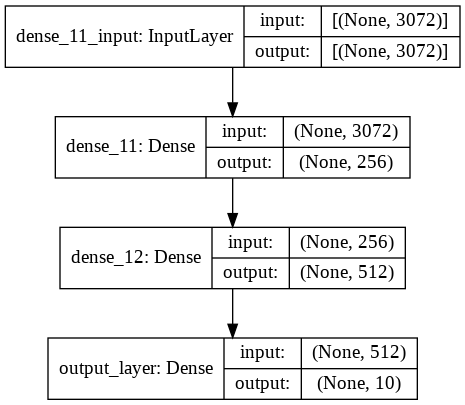

In [ ]:
keras.utils.plot_model(model3, "cifar_model3.png", show_shapes=True) 

In [ ]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_images_reshaped
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_reshaped,val_labels)
                    ,callbacks=[
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/model2_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/20
79/79 [==============================] - 1s 13ms/step - loss: 1.4012 - accuracy: 0.5050 - val_loss: 1.4596 - val_accuracy: 0.4808
Epoch 2/20
79/79 [==============================] - 1s 13ms/step - loss: 1.3840 - accuracy: 0.5080 - val_loss: 1.4402 - val_accuracy: 0.4908
Epoch 3/20
79/79 [==============================] - 1s 12ms/step - loss: 1.3660 - accuracy: 0.5178 - val_loss: 1.5219 - val_accuracy: 0.4584
Epoch 4/20
79/79 [==============================] - 1s 12ms/step - loss: 1.3565 - accuracy: 0.5177 - val_loss: 1.4347 - val_accuracy: 0.4950
Epoch 5/20
79/79 [==============================] - 1s 12ms/step - loss: 1.3279 - accuracy: 0.5275 - val_loss: 1.4279 - val_accuracy: 0.4921
Epoch 6/20
79/79 [==============================] - 1s 10ms/step - loss: 1.3137 - accuracy: 0.5340 - val_loss: 1.4245 - val_accuracy: 0.4953
Epoch 7/20
79/79 [==============================] - 1s 10ms/step - loss: 1.2886 - accuracy: 0.5458 - val_loss: 1.4293 - val_accuracy: 0.4961
Epoch 8/20
79

## Experiment 2

Experiment 2: DNN with 3 layers (no regularization)

In [ ]:
model2 = models.Sequential()
model2.add(layers.Dense(input_shape=[3072], units = 256, activation = tf.nn.relu))
model2.add(layers.Dense(units = 512, activation = tf.nn.relu))
model2.add(layers.Dense(units = 1024, activation = tf.nn.relu))
model2.add(layers.Dense(name = "output_layer", units = 10, activation = tf.nn.softmax))


In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               786688    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              525312    
_________________________________________________________________
output_layer (Dense)         (None, 10)                10250     
Total params: 1,453,834
Trainable params: 1,453,834
Non-trainable params: 0
_________________________________________________________________


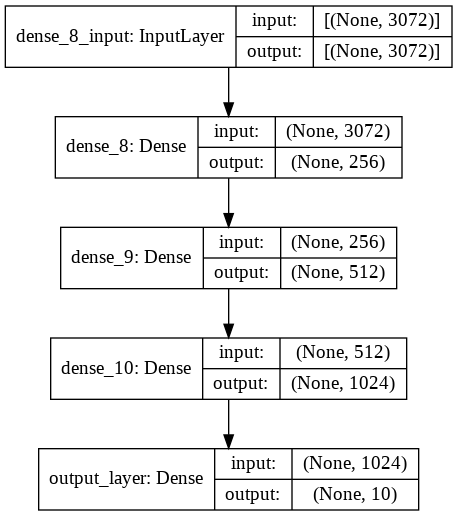

In [ ]:
keras.utils.plot_model(model2, "cifar_model2.png", show_shapes=True) 

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_images_reshaped
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_reshaped,val_labels)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/model2_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/20
79/79 [==============================] - 2s 19ms/step - loss: 2.0981 - accuracy: 0.2313 - val_loss: 1.8097 - val_accuracy: 0.3350
Epoch 2/20
79/79 [==============================] - 1s 17ms/step - loss: 1.7302 - accuracy: 0.3775 - val_loss: 1.6540 - val_accuracy: 0.3945
Epoch 3/20
79/79 [==============================] - 1s 17ms/step - loss: 1.6301 - accuracy: 0.4204 - val_loss: 1.5993 - val_accuracy: 0.4331
Epoch 4/20
79/79 [==============================] - 1s 16ms/step - loss: 1.5617 - accuracy: 0.4411 - val_loss: 1.5490 - val_accuracy: 0.4450
Epoch 5/20
79/79 [==============================] - 1s 16ms/step - loss: 1.5137 - accuracy: 0.4619 - val_loss: 1.5572 - val_accuracy: 0.4419
Epoch 6/20
79/79 [==============================] - 1s 16ms/step - loss: 1.4824 - accuracy: 0.4698 - val_loss: 1.5177 - val_accuracy: 0.4486
Epoch 7/20
79/79 [==============================] - 1s 17ms/step - loss: 1.4331 - accuracy: 0.4873 - val_loss: 1.5747 - val_accuracy: 0.4511
Epoch 8/20
79

## Experiment 3

Experiment 3: CNN with 2 convolution/max pooling layers (no regularization)

In [ ]:
model4 = models.Sequential()
model4.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(32, 32, 3)))
model4.add(layers.MaxPooling2D((2, 2),strides=2))
model4.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model4.add(layers.Flatten())
model4.add(layers.Dense(units=512, activation=tf.nn.relu))
model4.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 512)       1180160   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               9437696   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5

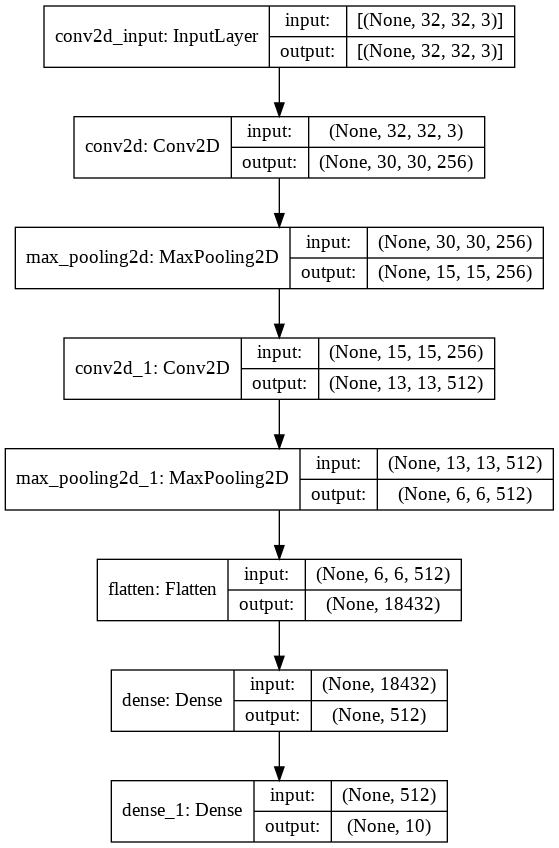

In [ ]:
keras.utils.plot_model(model4, "CIFAR10_model4.png", show_shapes=True) 

In [ ]:
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)
                    ,callbacks=[
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/model2_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/20
79/79 [==============================] - 103s 1s/step - loss: 2.0512 - accuracy: 0.2724 - val_loss: 1.4173 - val_accuracy: 0.4916
Epoch 2/20
79/79 [==============================] - 102s 1s/step - loss: 1.3895 - accuracy: 0.5062 - val_loss: 1.3283 - val_accuracy: 0.5333
Epoch 3/20
79/79 [==============================] - 102s 1s/step - loss: 1.2134 - accuracy: 0.5733 - val_loss: 1.2410 - val_accuracy: 0.5618
Epoch 4/20
79/79 [==============================] - 103s 1s/step - loss: 1.1067 - accuracy: 0.6102 - val_loss: 1.1117 - val_accuracy: 0.6050
Epoch 5/20
79/79 [==============================] - 101s 1s/step - loss: 0.9951 - accuracy: 0.6503 - val_loss: 0.9851 - val_accuracy: 0.6544
Epoch 6/20
79/79 [==============================] - 100s 1s/step - loss: 0.9145 - accuracy: 0.6842 - val_loss: 0.9823 - val_accuracy: 0.6567
Epoch 7/20
79/79 [==============================] - 101s 1s/step - loss: 0.8623 - accuracy: 0.7041 - val_loss: 0.9016 - val_accuracy: 0.6866
Epoch 8/20
79

In [ ]:
loss, accuracy = model4.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 6s 19ms/step - loss: 1.0584 - accuracy: 0.7178
test set accuracy:  71.78000211715698


## Experiment 1 with regularization


We will be using 20% dropout in hidden layers of the models.

In [ ]:
# Reshape the images:
train_images_reshaped = np.reshape(train_images_norm, (40000, 3072))
val_images_reshaped = np.reshape(val_images_norm, (10000, 3072))
test_images_reshaped = np.reshape(test_images_norm, (10000, 3072))


In [ ]:
model3_reg = models.Sequential()
model3_reg.add(layers.Dense(input_shape=[3072], units = 256, activation = tf.nn.relu))
model3_reg.add(layers.Dropout(.2))
model3_reg.add(layers.Dense(units = 512, activation = tf.nn.relu))
model3_reg.add(layers.Dropout(.2))
model3_reg.add(layers.Dense(name = "output_layer", units = 10, activation = tf.nn.softmax))


In [ ]:
model3_reg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               786688    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                5130      
Total params: 923,402
Trainable params: 923,402
Non-trainable params: 0
_________________________________________________________________


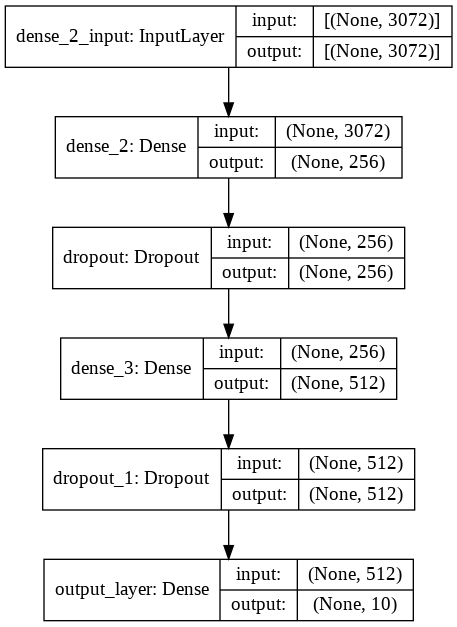

In [ ]:
keras.utils.plot_model(model3_reg, "cifar_model3_reg.png", show_shapes=True) 

In [ ]:
model3_reg.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history3_reg = model3_reg.fit(train_images_reshaped
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_reshaped,val_labels)
                    ,callbacks=[
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/model2_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/20
79/79 [==============================] - 2s 14ms/step - loss: 2.2188 - accuracy: 0.1953 - val_loss: 1.8482 - val_accuracy: 0.3342
Epoch 2/20
79/79 [==============================] - 1s 13ms/step - loss: 1.8591 - accuracy: 0.3276 - val_loss: 1.7388 - val_accuracy: 0.3756
Epoch 3/20
79/79 [==============================] - 1s 12ms/step - loss: 1.8041 - accuracy: 0.3546 - val_loss: 1.6897 - val_accuracy: 0.3895
Epoch 4/20
79/79 [==============================] - 1s 12ms/step - loss: 1.7447 - accuracy: 0.3722 - val_loss: 1.6575 - val_accuracy: 0.4062
Epoch 5/20
79/79 [==============================] - 1s 11ms/step - loss: 1.7081 - accuracy: 0.3885 - val_loss: 1.6303 - val_accuracy: 0.4266
Epoch 6/20
79/79 [==============================] - 1s 11ms/step - loss: 1.6874 - accuracy: 0.3951 - val_loss: 1.5949 - val_accuracy: 0.4261
Epoch 7/20
79/79 [==============================] - 1s 11ms/step - loss: 1.6571 - accuracy: 0.4076 - val_loss: 1.5861 - val_accuracy: 0.4352
Epoch 8/20
79

In [ ]:
loss, accuracy = model3_reg.evaluate(test_images_reshaped, test_labels)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 0s 1ms/step - loss: 1.4805 - accuracy: 0.4662
test set accuracy:  46.619999408721924


Experiment 2 with Regularization

In [ ]:
model2_reg = models.Sequential()
model2_reg .add(layers.Dense(input_shape=[3072], units = 256, activation = tf.nn.relu))
model2_reg.add(layers.Dropout(.2))
model2_reg .add(layers.Dense(units = 512, activation = tf.nn.relu))
model2_reg.add(layers.Dropout(.2))
model2_reg .add(layers.Dense(units = 1024, activation = tf.nn.relu))
model2_reg.add(layers.Dropout(.2))
model2_reg .add(layers.Dense(name = "output_layer", units = 10, activation = tf.nn.softmax))


In [ ]:
model2_reg.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               786688    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)               

In [ ]:
model2_reg.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history2_reg = model2_reg.fit(train_images_reshaped
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_reshaped,val_labels)
                    ,callbacks=[
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/model2_reg/model2_reg_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/20
79/79 [==============================] - 2s 18ms/step - loss: 2.1203 - accuracy: 0.2097 - val_loss: 1.8870 - val_accuracy: 0.3011
Epoch 2/20
79/79 [==============================] - 1s 15ms/step - loss: 1.8617 - accuracy: 0.3220 - val_loss: 1.7672 - val_accuracy: 0.3548
Epoch 3/20
79/79 [==============================] - 1s 16ms/step - loss: 1.8020 - accuracy: 0.3486 - val_loss: 1.7374 - val_accuracy: 0.3826
Epoch 4/20
79/79 [==============================] - 1s 16ms/step - loss: 1.7491 - accuracy: 0.3649 - val_loss: 1.6487 - val_accuracy: 0.4053
Epoch 5/20
79/79 [==============================] - 1s 16ms/step - loss: 1.7089 - accuracy: 0.3824 - val_loss: 1.6764 - val_accuracy: 0.3891
Epoch 6/20
79/79 [==============================] - 1s 16ms/step - loss: 1.6947 - accuracy: 0.3860 - val_loss: 1.6100 - val_accuracy: 0.4242
Epoch 7/20
79/79 [==============================] - 1s 16ms/step - loss: 1.6702 - accuracy: 0.3977 - val_loss: 1.5757 - val_accuracy: 0.4337
Epoch 8/20
79

In [ ]:
loss, accuracy = model2_reg.evaluate(test_images_reshaped, test_labels)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 2ms/step - loss: 1.4861 - accuracy: 0.4689
test set accuracy:  46.88999950885773


## Experiment 3 with regularization







In [ ]:
model4_reg = models.Sequential()
model4_reg.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(32, 32, 3)))
model4_reg.add(layers.MaxPooling2D((2, 2),strides=2))
model4_reg.add(layers.Dropout(.2))
model4_reg.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4_reg.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model4_reg.add(layers.Dropout(.2))
model4_reg.add(layers.Flatten())
model4_reg.add(layers.Dense(units=256, activation=tf.nn.relu))
model4_reg.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model4_reg.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 256)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 512)       1180160   
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 512)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 6, 6, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)            

In [ ]:
model4_reg.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history4_reg = model4_reg.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)
                    ,callbacks=[
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Experiment3_reg/model4_reg_{val_accuracy:.4f}.h5',
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/20
79/79 [==============================] - 109s 1s/step - loss: 1.3592 - accuracy: 0.5185 - val_loss: 1.3264 - val_accuracy: 0.5135
Epoch 2/20
79/79 [==============================] - 108s 1s/step - loss: 1.2099 - accuracy: 0.5739 - val_loss: 1.1301 - val_accuracy: 0.6017
Epoch 3/20
79/79 [==============================] - 108s 1s/step - loss: 1.0908 - accuracy: 0.6184 - val_loss: 1.0578 - val_accuracy: 0.6309
Epoch 4/20
79/79 [==============================] - 108s 1s/step - loss: 0.9970 - accuracy: 0.6507 - val_loss: 0.9909 - val_accuracy: 0.6471
Epoch 5/20
79/79 [==============================] - 105s 1s/step - loss: 0.9299 - accuracy: 0.6754 - val_loss: 0.9816 - val_accuracy: 0.6583
Epoch 6/20
79/79 [==============================] - 121s 2s/step - loss: 0.8876 - accuracy: 0.6907 - val_loss: 0.9193 - val_accuracy: 0.6792
Epoch 7/20
79/79 [==============================] - 121s 2s/step - loss: 0.8359 - accuracy: 0.7099 - val_loss: 0.8980 - val_accuracy: 0.6856
Epoch 8/20
79

In [ ]:
loss, accuracy = model4_reg.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 8s 24ms/step - loss: 0.8581 - accuracy: 0.7301
test set accuracy:  73.00999760627747


## Experiment 4 with regularization

In [ ]:
model_reg = models.Sequential()
model_reg.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(32, 32, 3)))
model_reg.add(layers.MaxPooling2D((2, 2),strides=2))
model_reg.add(layers.Dropout(.2))
model_reg.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_reg.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model_reg.add(layers.Dropout(.2))
model_reg.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_reg.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model_reg.add(layers.Dropout(.2))
model_reg.add(layers.Flatten())
model_reg.add(layers.Dense(units=512, activation=tf.nn.relu))
model_reg.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model_reg.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 256)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 512)       1180160   
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 512)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 6, 6, 512)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 1024)       

In [ ]:
model_reg.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history_reg = model_reg.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)
                    ,callbacks=[
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Experiment4_reg/model_reg_{val_accuracy:.4f}.h5',
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/20
79/79 [==============================] - 247s 3s/step - loss: 2.1255 - accuracy: 0.2019 - val_loss: 1.8487 - val_accuracy: 0.3433
Epoch 2/20
79/79 [==============================] - 182s 2s/step - loss: 1.5661 - accuracy: 0.4261 - val_loss: 1.2923 - val_accuracy: 0.5326
Epoch 3/20
79/79 [==============================] - 191s 2s/step - loss: 1.2863 - accuracy: 0.5364 - val_loss: 1.4547 - val_accuracy: 0.4910
Epoch 4/20
79/79 [==============================] - 190s 2s/step - loss: 1.2236 - accuracy: 0.5713 - val_loss: 1.1152 - val_accuracy: 0.6009
Epoch 5/20
79/79 [==============================] - 202s 3s/step - loss: 1.0535 - accuracy: 0.6288 - val_loss: 1.0443 - val_accuracy: 0.6379
Epoch 6/20
79/79 [==============================] - 197s 2s/step - loss: 0.9807 - accuracy: 0.6592 - val_loss: 0.9310 - val_accuracy: 0.6752
Epoch 7/20
79/79 [==============================] - 195s 2s/step - loss: 0.8816 - accuracy: 0.6929 - val_loss: 0.8747 - val_accuracy: 0.6951
Epoch 8/20
79

## Experiment 1 with batch normalization

In [ ]:
# Reshape the images:
train_images_reshaped = np.reshape(train_images_norm, (40000, 3072))
val_images_reshaped = np.reshape(val_images_norm, (10000, 3072))
test_images_reshaped = np.reshape(test_images_norm, (10000, 3072))

In [ ]:
model3_batch = models.Sequential()
model3_batch.add(layers.Dense(input_shape=[3072], units = 256, activation = tf.nn.relu))
model3_batch.add(BatchNormalization())
model3_batch.add(layers.Dense(units = 512, activation = tf.nn.relu))
model3_batch.add(BatchNormalization())
model3_batch.add(layers.Dense(name = "output_layer", units = 10, activation = tf.nn.softmax))


In [ ]:
model3_batch.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               786688    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
output_layer (Dense)         (None, 10)                5130      
Total params: 926,474
Trainable params: 924,938
Non-trainable params: 1,536
_________________________________________________________________


In [ ]:
model3_batch.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history3_batch = model3_batch.fit(train_images_reshaped
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_reshaped,val_labels)
                    ,callbacks=[
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Experiment1_batch_normalization/model3_batch_{val_accuracy:.4f}.h5',
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/20
79/79 [==============================] - 2s 20ms/step - loss: 1.9947 - accuracy: 0.3368 - val_loss: 2.2286 - val_accuracy: 0.2482
Epoch 2/20
79/79 [==============================] - 1s 16ms/step - loss: 1.5365 - accuracy: 0.4589 - val_loss: 1.7665 - val_accuracy: 0.3697
Epoch 3/20
79/79 [==============================] - 1s 17ms/step - loss: 1.4483 - accuracy: 0.4899 - val_loss: 1.6999 - val_accuracy: 0.4098
Epoch 4/20
79/79 [==============================] - 1s 17ms/step - loss: 1.3735 - accuracy: 0.5198 - val_loss: 1.8848 - val_accuracy: 0.3469
Epoch 5/20
79/79 [==============================] - 1s 18ms/step - loss: 1.3036 - accuracy: 0.5485 - val_loss: 2.0828 - val_accuracy: 0.3429
Epoch 6/20
79/79 [==============================] - 1s 18ms/step - loss: 1.2571 - accuracy: 0.5589 - val_loss: 2.5742 - val_accuracy: 0.2860
Epoch 7/20
79/79 [==============================] - 2s 20ms/step - loss: 1.2107 - accuracy: 0.5728 - val_loss: 1.6839 - val_accuracy: 0.4251
Epoch 8/20
79

In [ ]:
loss, accuracy = model3_batch.evaluate(test_images_reshaped, test_labels)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 2ms/step - loss: 2.3582 - accuracy: 0.3765
test set accuracy:  37.65000104904175


## Experiment 2 with Batch Normalization

In [ ]:
model2_batch = models.Sequential()
model2_batch.add(layers.Dense(input_shape=[3072], units = 256, activation = tf.nn.relu))
model2_batch.add(BatchNormalization())
model2_batch.add(layers.Dense(units = 512, activation = tf.nn.relu))
model2_batch.add(BatchNormalization())
model2_batch.add(layers.Dense(units = 1024, activation = tf.nn.relu))
model2_batch.add(BatchNormalization())
model2_batch.add(layers.Dense(name = "output_layer", units = 10, activation = tf.nn.softmax))


In [ ]:
model2_batch.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               786688    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_6 (Batch (None, 1024)              4096      
_________________________________________________________________
output_layer (Dense)         (None, 10)               

In [ ]:
model2_batch.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history2_batch = model2_batch.fit(train_images_reshaped
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_reshaped,val_labels)
                    ,callbacks=[
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Experiment2_batch_normalization/model2_batch_{val_accuracy:.4f}.h5',
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/20
79/79 [==============================] - 3s 28ms/step - loss: 2.0599 - accuracy: 0.3289 - val_loss: 2.1999 - val_accuracy: 0.2326
Epoch 2/20
79/79 [==============================] - 2s 30ms/step - loss: 1.5067 - accuracy: 0.4695 - val_loss: 1.9396 - val_accuracy: 0.3091
Epoch 3/20
79/79 [==============================] - 3s 33ms/step - loss: 1.3901 - accuracy: 0.5045 - val_loss: 1.8976 - val_accuracy: 0.3404
Epoch 4/20
79/79 [==============================] - 2s 31ms/step - loss: 1.2876 - accuracy: 0.5474 - val_loss: 1.7498 - val_accuracy: 0.3928
Epoch 5/20
79/79 [==============================] - 2s 26ms/step - loss: 1.2097 - accuracy: 0.5719 - val_loss: 1.8777 - val_accuracy: 0.3731
Epoch 6/20
79/79 [==============================] - 2s 27ms/step - loss: 1.1376 - accuracy: 0.5961 - val_loss: 1.9439 - val_accuracy: 0.3784
Epoch 7/20
79/79 [==============================] - 2s 27ms/step - loss: 1.0655 - accuracy: 0.6231 - val_loss: 2.2203 - val_accuracy: 0.3350
Epoch 8/20
79

In [ ]:
loss, accuracy = model2_batch.evaluate(test_images_reshaped, test_labels)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 3ms/step - loss: 2.2641 - accuracy: 0.4477
test set accuracy:  44.769999384880066


## Experiment 3 with batch normalization

In [ ]:
model4_batch = models.Sequential()
model4_batch.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(32, 32, 3)))
model4_batch.add(layers.MaxPooling2D((2, 2),strides=2))
model4_batch.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4_batch.add(BatchNormalization())
model4_batch.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model4_batch.add(layers.Flatten())
model4_batch.add(layers.Dense(units=256, activation=tf.nn.relu))
model4_batch.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model4_batch.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 512)       1180160   
_________________________________________________________________
batch_normalization_13 (Batc (None, 13, 13, 512)       2048      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 512)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)              

In [ ]:
model4_batch.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history4_batch = model4_batch.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)
                    ,callbacks=[
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Experiment3_batch_normalization/model4_batch_{val_accuracy:.4f}.h5',
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/20
79/79 [==============================] - 97s 1s/step - loss: 1.9745 - accuracy: 0.3898 - val_loss: 2.1123 - val_accuracy: 0.1439
Epoch 2/20
79/79 [==============================] - 99s 1s/step - loss: 0.9976 - accuracy: 0.6520 - val_loss: 1.9575 - val_accuracy: 0.2772
Epoch 3/20
79/79 [==============================] - 98s 1s/step - loss: 0.7730 - accuracy: 0.7342 - val_loss: 1.6462 - val_accuracy: 0.5008
Epoch 4/20
79/79 [==============================] - 97s 1s/step - loss: 0.6291 - accuracy: 0.7843 - val_loss: 1.5533 - val_accuracy: 0.4951
Epoch 5/20
79/79 [==============================] - 97s 1s/step - loss: 0.4816 - accuracy: 0.8399 - val_loss: 1.0495 - val_accuracy: 0.6799
Epoch 6/20
79/79 [==============================] - 98s 1s/step - loss: 0.3325 - accuracy: 0.8925 - val_loss: 1.0156 - val_accuracy: 0.6418
Epoch 7/20
79/79 [==============================] - 96s 1s/step - loss: 0.2310 - accuracy: 0.9274 - val_loss: 0.9188 - val_accuracy: 0.6944
Epoch 8/20
79/79 [==

In [ ]:
loss, accuracy = model4_batch.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 6s 19ms/step - loss: 1.3383 - accuracy: 0.7458
test set accuracy:  74.58000183105469


## Experiment 4 with Batch Normalization

In [ ]:
model_batch = models.Sequential()
model_batch.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(32, 32, 3)))
model_batch.add(layers.MaxPooling2D((2, 2),strides=2))
model_batch.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_batch.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model_batch.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_batch.add(BatchNormalization())
model_batch.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model_batch.add(layers.Flatten())
model_batch.add(layers.Dense(units=512, activation=tf.nn.relu))
model_batch.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model_batch.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 512)       1180160   
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 512)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 1024)        4719616   
_________________________________________________________________
batch_normalization_14 (Batc (None, 4, 4, 1024)        4096      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 2, 2, 1024)       

In [ ]:
model_batch.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history_batch = model_batch.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)
                    ,callbacks=[
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Experiment4_batch_normalization/model_batch_{val_accuracy:.4f}.h5',
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/20
79/79 [==============================] - 184s 2s/step - loss: 1.9034 - accuracy: 0.3588 - val_loss: 2.1402 - val_accuracy: 0.3177
Epoch 2/20
79/79 [==============================] - 165s 2s/step - loss: 1.0613 - accuracy: 0.6225 - val_loss: 1.9990 - val_accuracy: 0.4421
Epoch 3/20
79/79 [==============================] - 164s 2s/step - loss: 0.8425 - accuracy: 0.7034 - val_loss: 1.7393 - val_accuracy: 0.4888
Epoch 4/20
79/79 [==============================] - 165s 2s/step - loss: 0.7104 - accuracy: 0.7526 - val_loss: 1.3450 - val_accuracy: 0.6468
Epoch 5/20
79/79 [==============================] - 168s 2s/step - loss: 0.5856 - accuracy: 0.7965 - val_loss: 1.0431 - val_accuracy: 0.6672
Epoch 6/20
79/79 [==============================] - 167s 2s/step - loss: 0.4974 - accuracy: 0.8280 - val_loss: 1.0038 - val_accuracy: 0.6518
Epoch 7/20
79/79 [==============================] - 166s 2s/step - loss: 0.3668 - accuracy: 0.8759 - val_loss: 0.8318 - val_accuracy: 0.7146
Epoch 8/20
79

In [ ]:
loss, accuracy = model_batch.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 8s 27ms/step - loss: 1.4995 - accuracy: 0.7067
test set accuracy:  70.67000269889832


load best model from that training. Best model at epoch 15. Migh want to use early stopping

In [ ]:
model_batch_best = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Experiment4_batch_normalization/model_batch_0.7703.h5')

In [ ]:
loss, accuracy = model_batch_best.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 8s 26ms/step - loss: 1.1578 - accuracy: 0.7713
test set accuracy:  77.13000178337097


In [ ]:
from keras import models

layer_outputs = [layer.output for layer in model_batch_best.layers[:8]]               
activation_model = models.Model(inputs=model_batch_best.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(train_images_norm[0]) 

ValueError: ignored

## Develop Model using data augmentation

We are going to horizontally flip the image and 10% shifts in height and width of image.

In [ ]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
#datagen.fit(train_images)

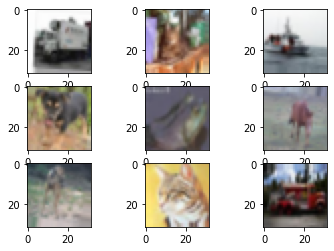

In [ ]:
# see example augmentation images
for X_batch, y_batch in datagen.flow(train_images, train_labels, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [ ]:
train_images_norm = train_images.astype('float32')/255.
test_images_norm = test_images.astype('float32')/255.

In [ ]:
val_images_norm, train_images_norm = train_images_norm[:10000], train_images_norm[10000:] 
val_labels, train_labels = train_labels[:10000], train_labels[10000:]

In [ ]:
model_aug = models.Sequential()
model_aug.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(32, 32, 3)))
model_aug.add(layers.MaxPooling2D((2, 2),strides=2))
model_aug.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_aug.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model_aug.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_aug.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model_aug.add(layers.Flatten())
model_aug.add(layers.Dense(units=512, activation=tf.nn.relu))
model_aug.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model_aug.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 13, 13, 512)       1180160   
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 6, 6, 512)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 4, 4, 1024)        4719616   
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 2, 2, 1024)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4096)            

In [ ]:
model_aug.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history_aug = model_aug.fit_generator(datagen.flow(train_images_norm, train_labels, batch_size=512)
                    ,steps_per_epoch=int(train_images_norm.shape[0] /512)
                    ,epochs=20
                    #,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Experiment4_aug/model_aug_{val_accuracy:.4f}.h5',
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/20
78/78 [==============================] - 216s 3s/step - loss: 2.0831 - accuracy: 0.1935 - val_loss: 1.5884 - val_accuracy: 0.1001
Epoch 2/20
55/78 [====================>.........] - ETA: 58s - loss: 1.5807 - accuracy: 0.0964 

KeyboardInterrupt: ignored

## Normalization and Dropout

In [ ]:
model_all = models.Sequential()
model_all.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(32, 32, 3)))
model_all.add(layers.MaxPooling2D((2, 2),strides=2))
model_all.add(layers.Dropout(.2))
model_all.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_all.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model_all.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_all.add(BatchNormalization())
model_all.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model_all.add(layers.Dropout(.2))
model_all.add(layers.Flatten())
model_all.add(layers.Dense(units=512, activation=tf.nn.relu))
model_all.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model_all.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 15, 15, 256)       0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 13, 13, 512)       1180160   
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 6, 6, 512)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 4, 1024)        4719616   
_________________________________________________________________
batch_normalization_5 (Batch (None, 4, 4, 1024)       

In [ ]:
model_all.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Increase patience to 5

In [ ]:

history_aug = model_all.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Experiment4_dropbatch/model_dropbatch_{val_accuracy:.4f}.h5',
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/20
79/79 [==============================] - 186s 2s/step - loss: 1.2772 - accuracy: 0.5439 - val_loss: 2.0733 - val_accuracy: 0.4329
Epoch 2/20
79/79 [==============================] - 171s 2s/step - loss: 0.9919 - accuracy: 0.6527 - val_loss: 1.8349 - val_accuracy: 0.6050
Epoch 3/20
79/79 [==============================] - 175s 2s/step - loss: 0.8322 - accuracy: 0.7071 - val_loss: 1.6014 - val_accuracy: 0.6410
Epoch 4/20
79/79 [==============================] - 183s 2s/step - loss: 0.7268 - accuracy: 0.7468 - val_loss: 1.2852 - val_accuracy: 0.6173
Epoch 5/20
79/79 [==============================] - 170s 2s/step - loss: 0.6349 - accuracy: 0.7771 - val_loss: 1.0588 - val_accuracy: 0.6501
Epoch 6/20
79/79 [==============================] - 177s 2s/step - loss: 0.5461 - accuracy: 0.8117 - val_loss: 0.9112 - val_accuracy: 0.6822
Epoch 7/20
79/79 [==============================] - 172s 2s/step - loss: 0.4695 - accuracy: 0.8334 - val_loss: 0.7641 - val_accuracy: 0.7349
Epoch 8/20
79

In [ ]:
#load best model at epoch 13
model_all = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Experiment4_dropbatch/model_dropbatch_0.7712.h5')

OSError: ignored

In [ ]:
loss, accuracy = model_all.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 7s 23ms/step - loss: 0.8965 - accuracy: 0.7666
test set accuracy:  76.66000127792358


## Add one more layer to best model layout

In [ ]:
model_best = models.Sequential()
model_best.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(32, 32, 3)))
model_best.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_best.add(layers.MaxPooling2D((2, 2),strides=2))
model_best.add(layers.Dropout(.2))
model_best.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_best.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model_best.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_best.add(BatchNormalization())
model_best.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model_best.add(layers.Dropout(.2))
model_best.add(layers.Flatten())
model_best.add(layers.Dense(units=512, activation=tf.nn.relu))
model_best.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model_best.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 256)       7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       590080    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 512)       1180160   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 512)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 1024)        4

In [ ]:
model_best.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:

history_best = model_best.fit(train_images_norm
                    ,train_labels
                    ,epochs=10
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)                                                                                                          
                    ])

Epoch 1/10
79/79 [==============================] - 426s 5s/step - loss: 2.0579 - accuracy: 0.3302 - val_loss: 2.1136 - val_accuracy: 0.4122
Epoch 2/10
79/79 [==============================] - 411s 5s/step - loss: 1.1117 - accuracy: 0.6041 - val_loss: 2.0857 - val_accuracy: 0.2728
Epoch 3/10
79/79 [==============================] - 422s 5s/step - loss: 0.8644 - accuracy: 0.6969 - val_loss: 1.6658 - val_accuracy: 0.4793
Epoch 4/10
55/79 [===================>..........] - ETA: 2:08 - loss: 0.7073 - accuracy: 0.7499

In [ ]:
#load best model at epoch 14
model_best = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Experiment4_best/model_best_0.7928.h5')

In [ ]:
loss, accuracy = model_all.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 14s 46ms/step - loss: 0.8687 - accuracy: 0.7885
test set accuracy:  78.85000109672546


In [ ]:
pred_classes = np.argmax(model_best.predict(train_images_norm), axis=-1)
pred_classes

array([1, 6, 6, ..., 9, 1, 1])

In [ ]:
conf_mx = tf.math.confusion_matrix(train_labels, pred_classes)
conf_mx

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[3857,    0,   42,   10,   38,    1,   15,   10,   19,    3],
       [   2, 3973,    5,    3,    1,    0,   15,    4,    9,   14],
       [   4,    0, 3878,    9,   17,    1,   55,    3,    1,    0],
       [   4,    0,   22, 3839,   10,   22,   69,   15,    3,    0],
       [   2,    0,   20,    6, 3898,    0,   67,    8,    0,    0],
       [   2,    1,   31,   60,   38, 3836,   57,   37,    0,    1],
       [   1,    1,    2,    4,    1,    0, 3959,    0,    1,    1],
       [   0,    0,    7,    1,    3,    0,    4, 3983,    1,    0],
       [   2,    0,    8,    4,    5,    0,   11,    1, 3942,    2],
       [   2,    7,    3,   11,    2,    1,   15,    7,    6, 3965]],
      dtype=int32)>

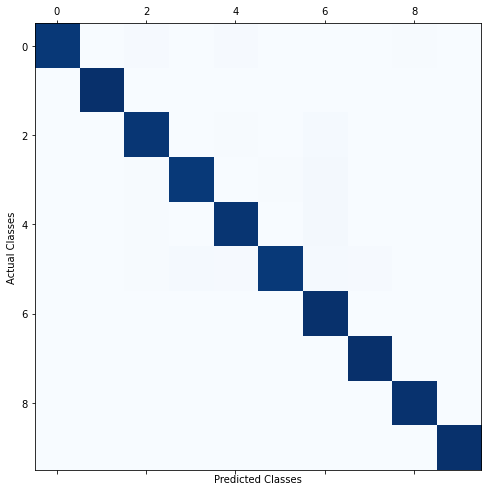

In [ ]:
plt.figure(figsize=(16,8))
plt.matshow(conf_mx, cmap=plt.cm.Blues,fignum=1)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()

In [ ]:
preds = model_best.predict(test_images_norm)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.00%,0.00%,0.01%,59.62%,0.01%,23.13%,17.22%,0.00%,0.00%,0.00%
1,0.00%,0.59%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,99.41%,0.00%
2,0.05%,59.27%,0.00%,0.02%,0.00%,0.00%,0.00%,0.00%,40.60%,0.07%
3,99.71%,0.00%,0.01%,0.00%,0.01%,0.00%,0.00%,0.00%,0.27%,0.00%
4,0.00%,0.00%,0.00%,0.01%,0.08%,0.00%,99.91%,0.00%,0.00%,0.00%
5,0.00%,0.00%,0.00%,0.00%,0.00%,0.11%,99.89%,0.00%,0.00%,0.00%
6,0.00%,97.71%,0.00%,0.00%,0.00%,0.01%,0.00%,0.00%,0.00%,2.27%
7,0.00%,0.00%,0.02%,0.00%,0.01%,0.00%,99.97%,0.00%,0.00%,0.00%
8,0.00%,0.00%,0.00%,99.99%,0.00%,0.00%,0.01%,0.00%,0.00%,0.00%
9,0.06%,39.93%,0.01%,0.02%,0.31%,0.02%,1.90%,0.00%,0.01%,57.74%


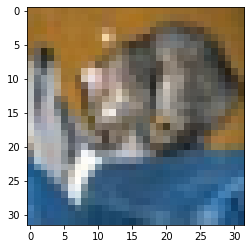

In [ ]:
plt.imshow(test_images_norm[0])

In [ ]:
def show_feats(model,image):
  image_batch=np.expand_dims(image,axis=0)
  conv_img=model.predict(image_batch)

  conv_img=np.squeeze(conv_img,axis=0)
  conv_img=conv_img.reshape(con_img.shape[:2])

  plt.imshow(conv_img)

In [ ]:
show_feats(model_best,train_images)

ValueError: ignored

In [ ]:
from tensorflow.keras.models import Model
inp= model_best.inputs 
print(inp)
out1= model_best.layers[0]. output  
print(out1)
feature_map_1= Model(inputs= inp, outputs= out1)  
feature_map_1.summary()


[<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'conv2d_65_input')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 30, 30, 256), dtype=tf.float32, name=None), name='conv2d_65/Relu:0', description="created by layer 'conv2d_65'")
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65_input (InputLayer) [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 30, 30, 256)       7168      
Total params: 7,168
Trainable params: 7,168
Non-trainable params: 0
_________________________________________________________________


TypeError: ignored

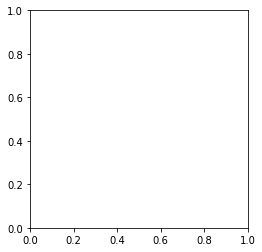

In [ ]:
img=cv2.imread("/content/gdrive/My Drive/Colab Notebooks/truck.png")
plt.imshow(img)

(1, 32, 32, 3)
(1, 30, 30, 256)


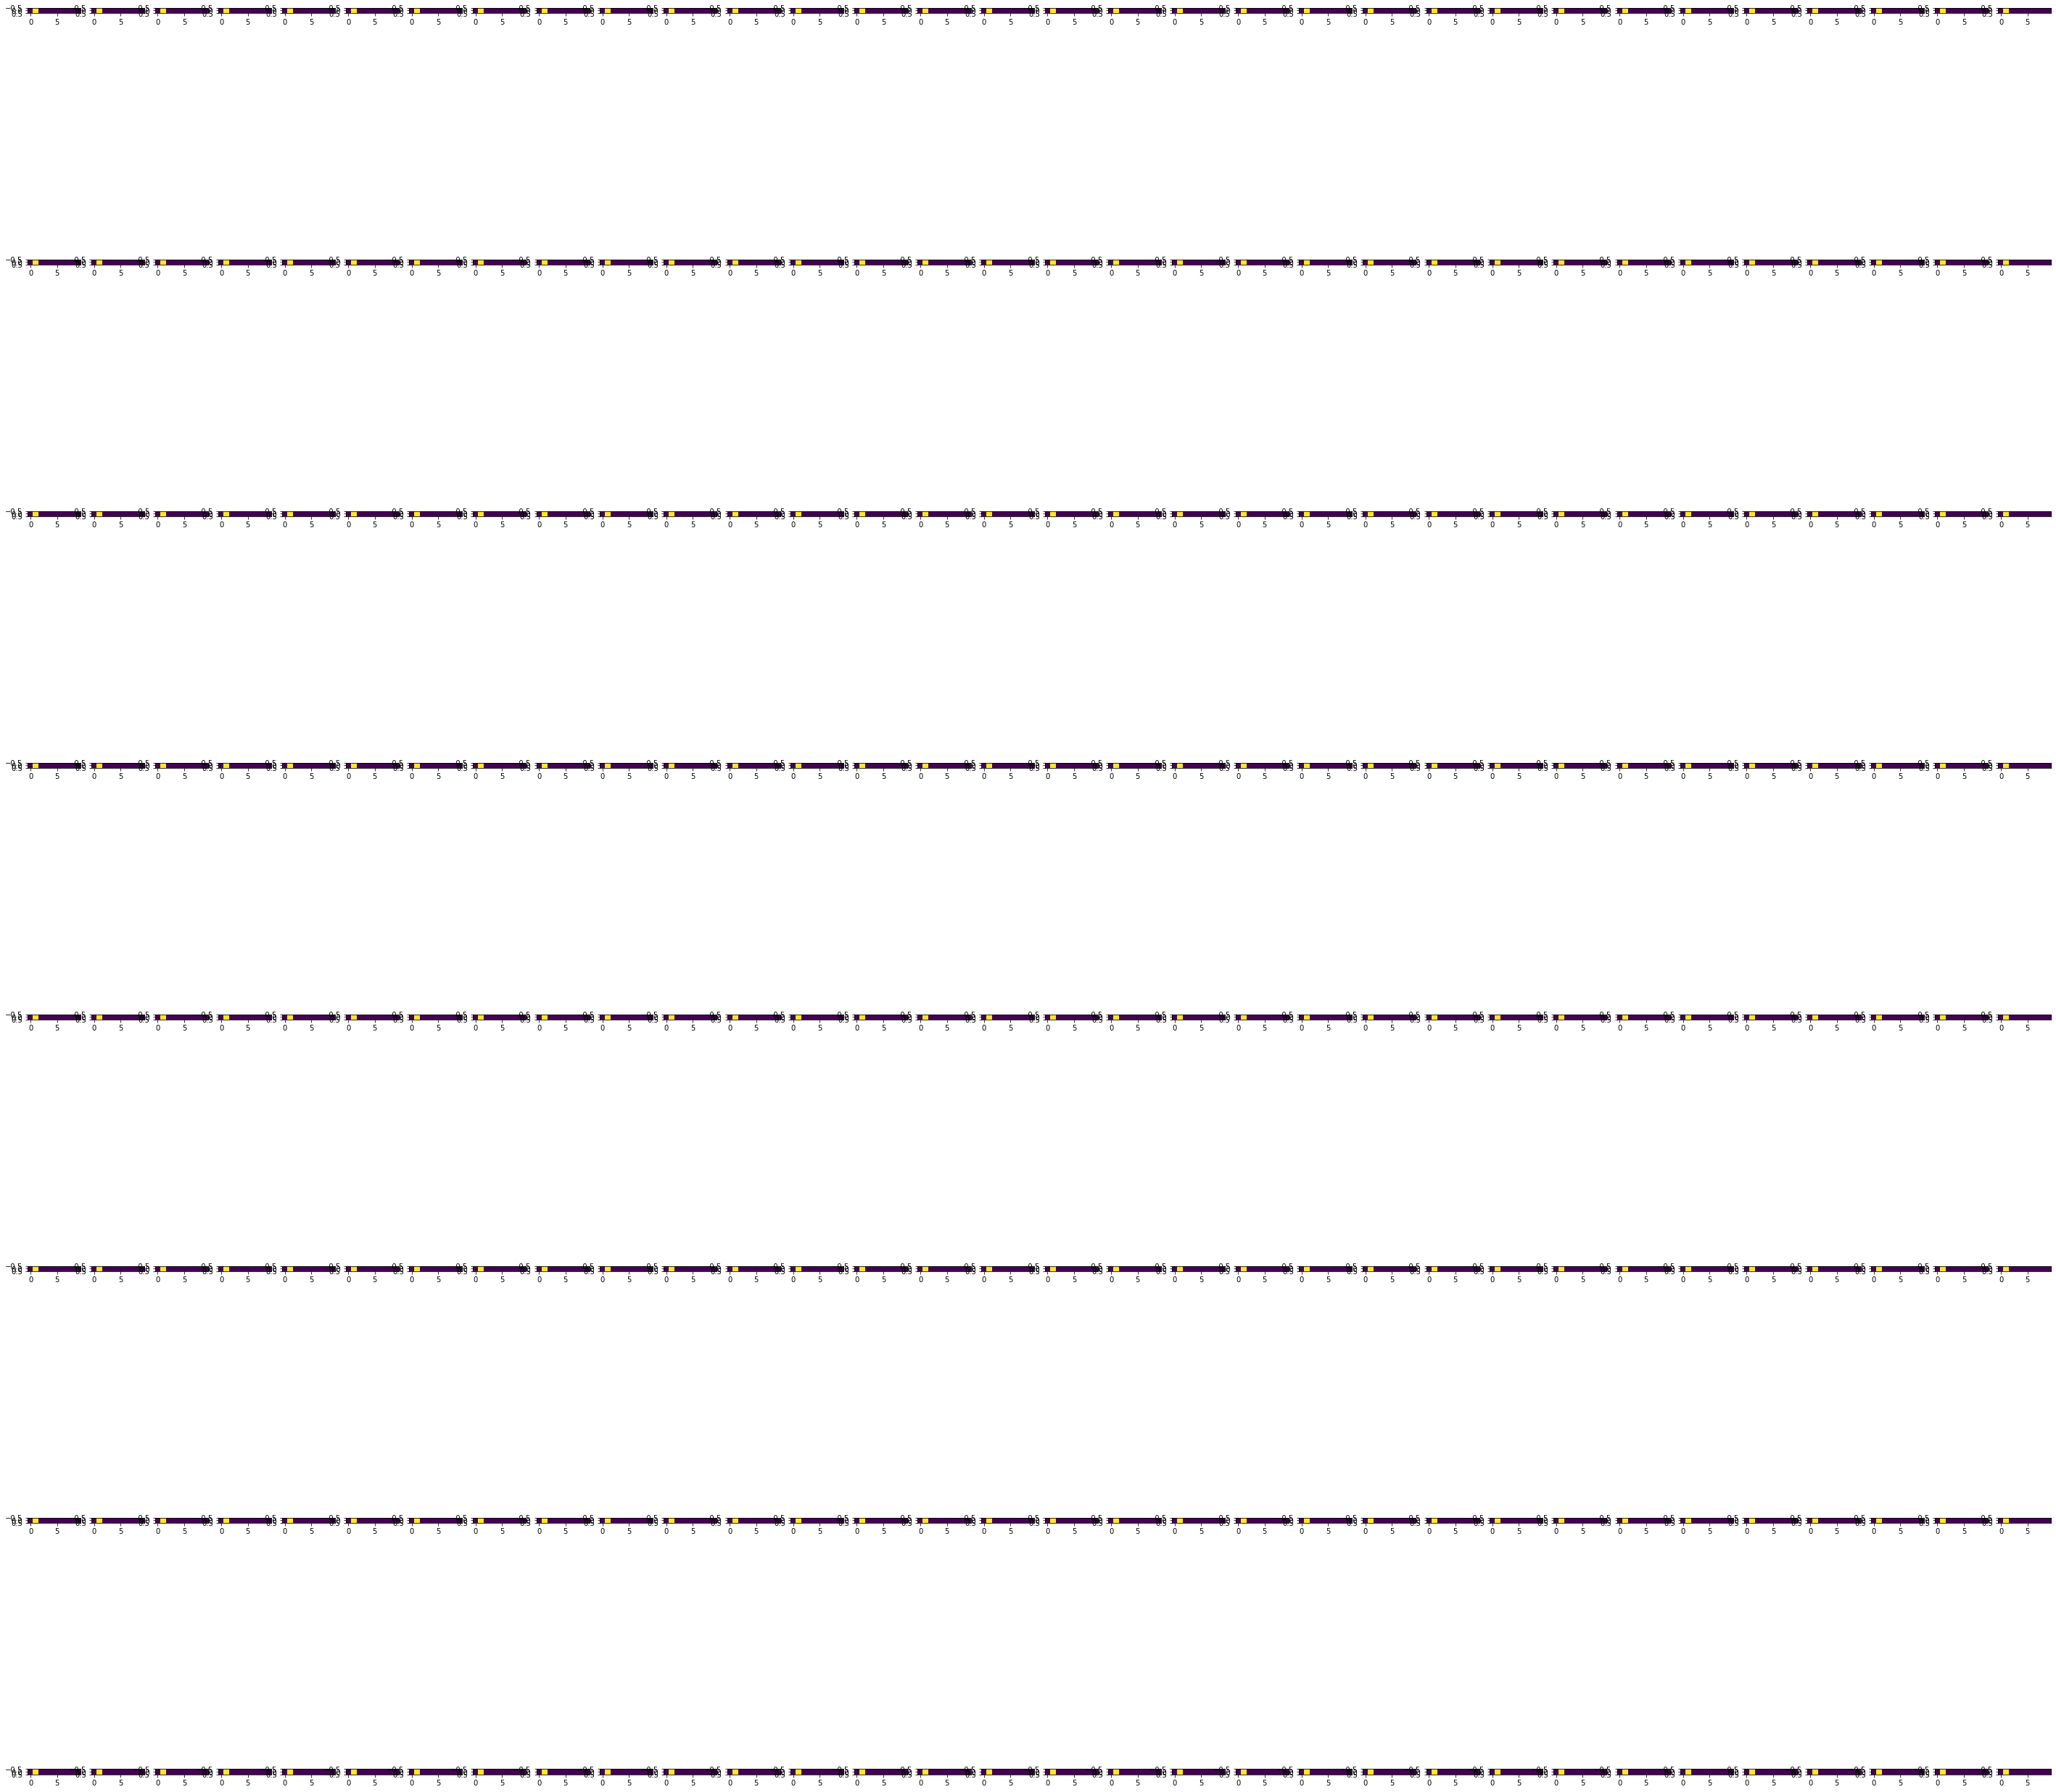

In [ ]:
img=np.expand_dims(train_images_norm[0],axis=0)
print(img.shape) 
img_s=feature_map_1.predict(img)
print(img_s.shape)
def show(x):
  image=np.squeeze(x,axis=0)
  plt.imshow(image)
fig= plt.figure(figsize=(50,50))
for i in range(256):
    ax=fig.add_subplot(8,32,i+1)
    ax.imshow(f1)

In [ ]:
img

In [ ]:
import cv2
img=cv2.imread(train_images_norm[0])                   # Reading an Image
img=cv2.resize(img,(32,32))
input_img= np.expand_dims(img, axis=0)      # Expanding the dimension
                      # Printing out the size of the Input Image

#-------------------------------------#-----------------------------------------#-----------------------------------------
f1=model_best.predict(input_img)        # predicting out the Image 
                           # Let's see the shape

fig= plt.figure(figsize=(50,50))
for i in range(32):
    ax=fig.add_subplot(8,4,i+1)
    ax.imshow(f1[0,:,:,i])

SystemError: ignored

(3, 3, 3, 256) (256,)


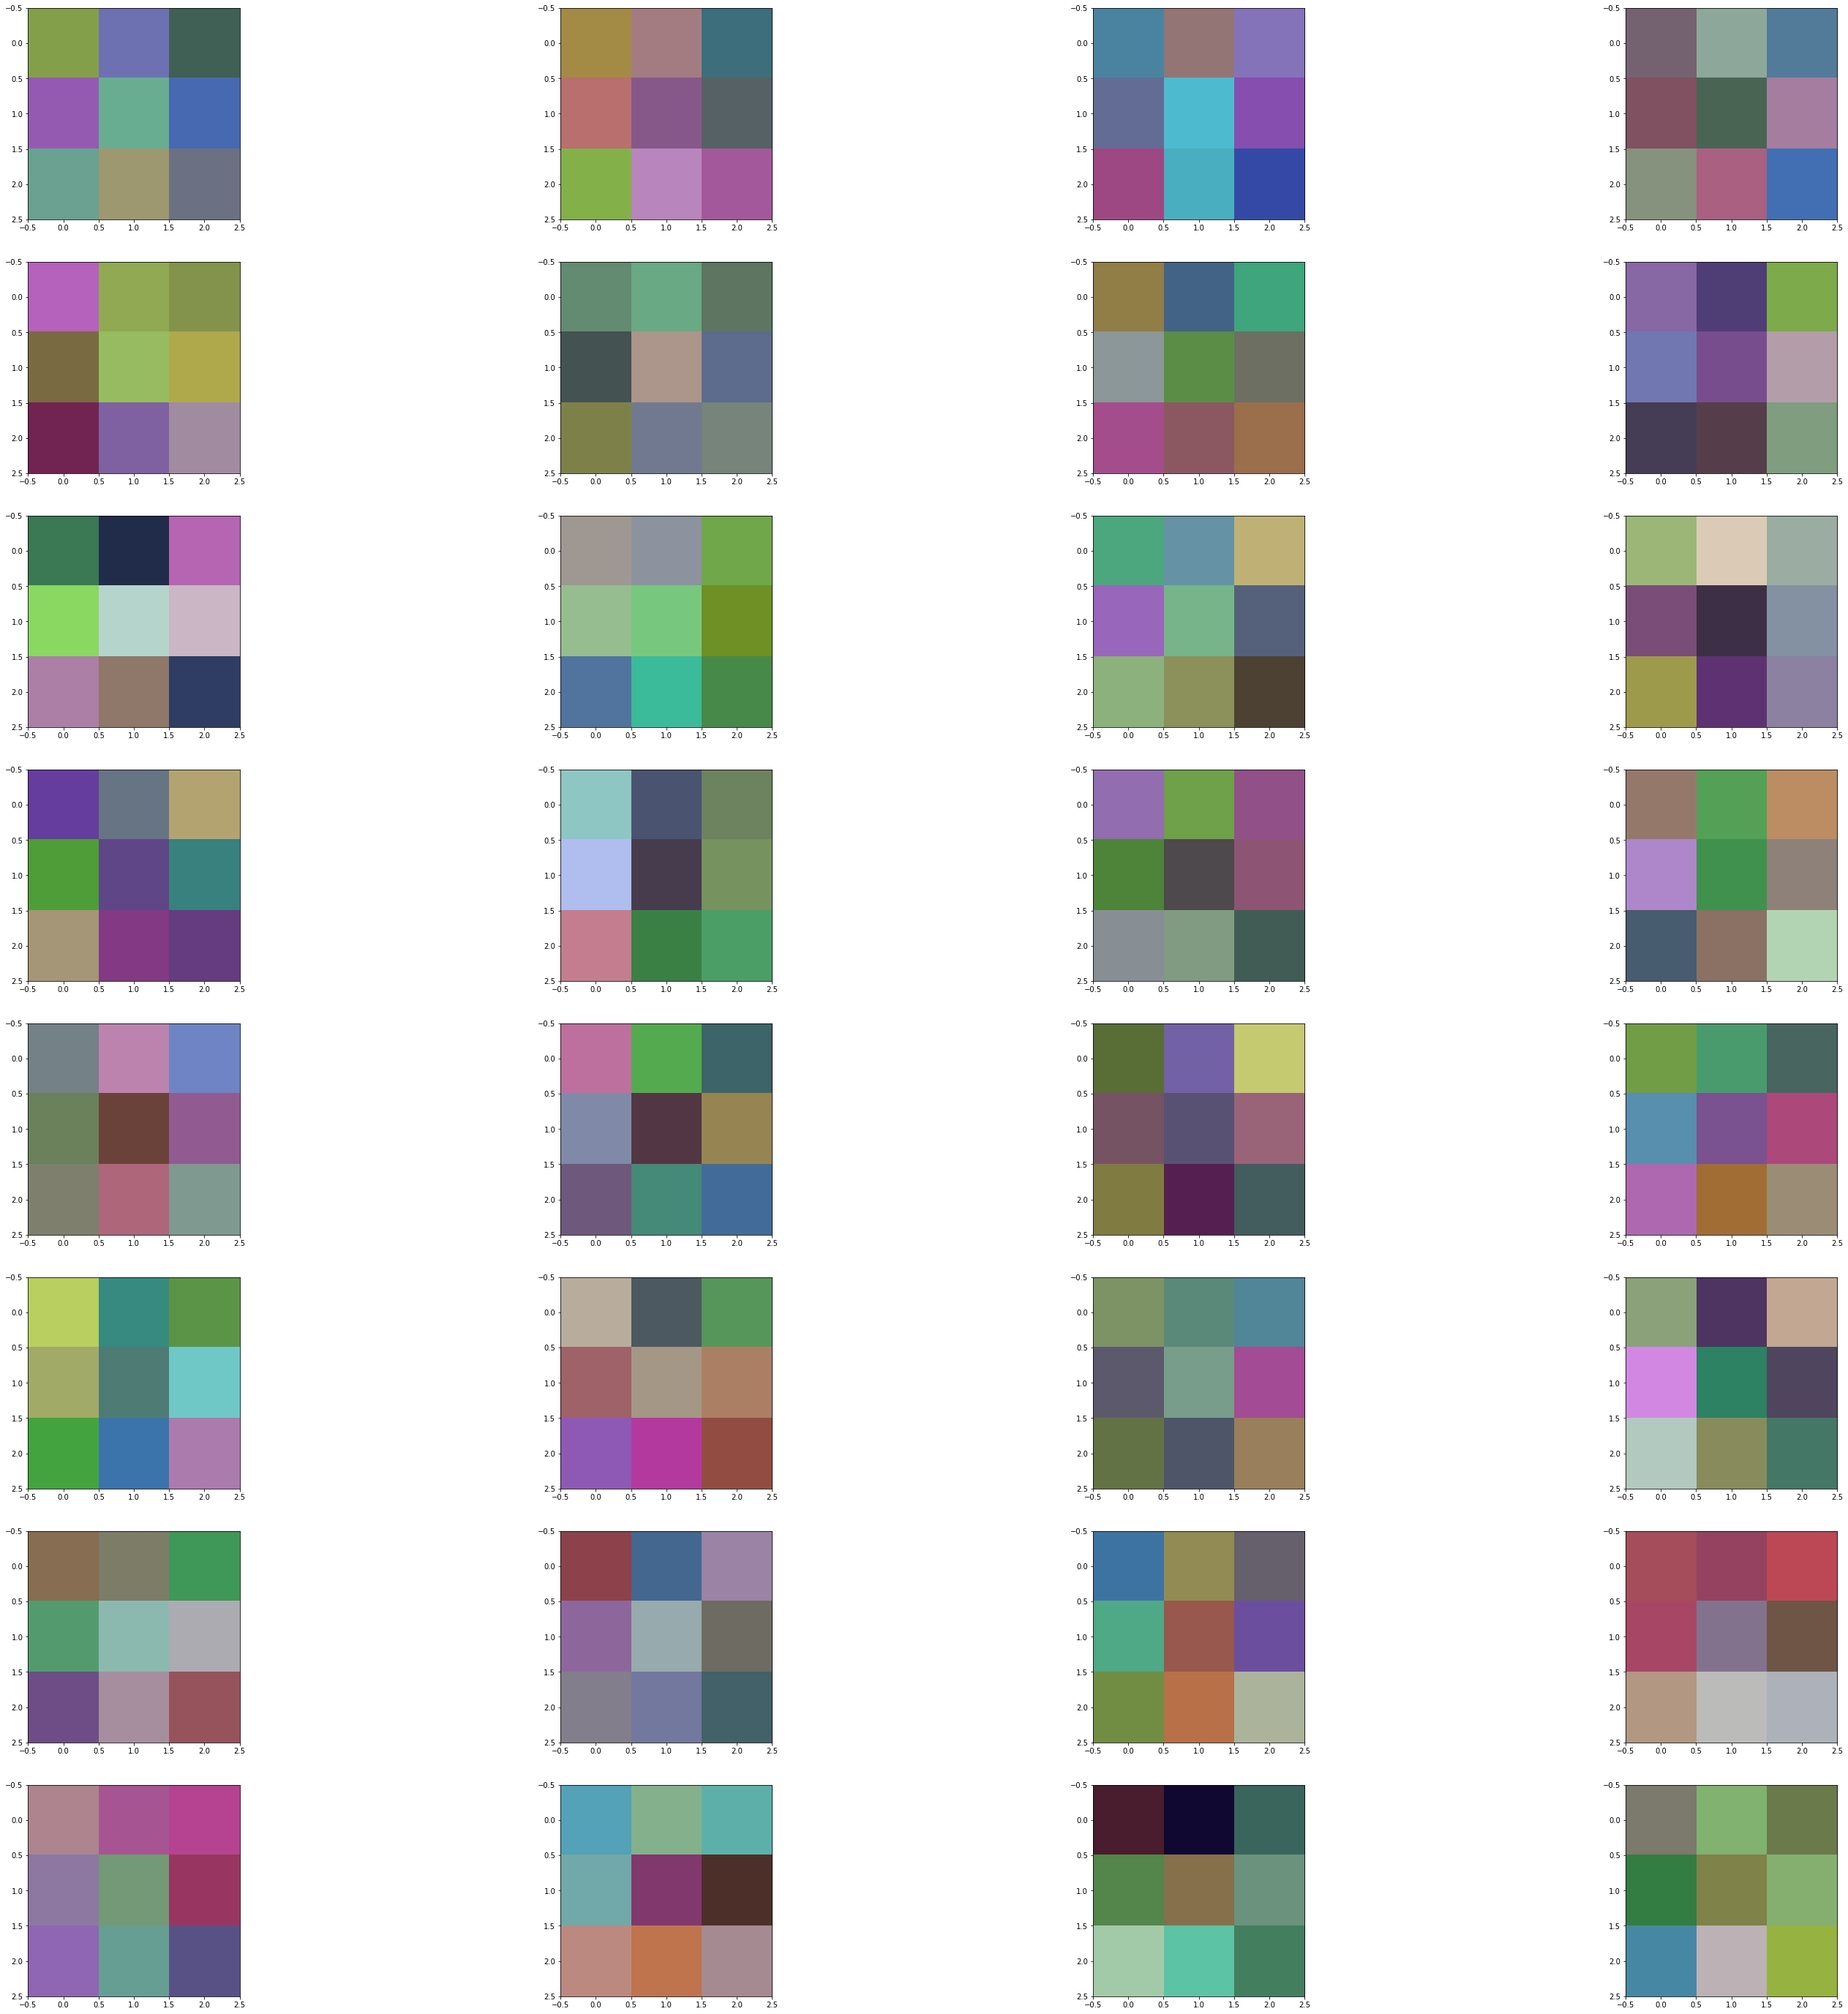

In [ ]:
layer= model_best.layers
layer_1= layer[0]
filter_1, bias_1= layer_1.get_weights()
print(filter_1.shape, bias_1.shape)

#Normalize the weights
f_min, f_max = filter_1.min(), filter_1.max()
filter_1 = (filter_1 - f_min) / (f_max - f_min)

fig= plt.figure(figsize=(50,50))
for i in range(32):
    ax = fig.add_subplot(8,4,i+1)
    ax.imshow(filter_1[:,:,:,i], cmap='gray')

In [ ]:
img_path = '/content/gdrive/My Drive/frog_32_thumb.png'

from keras.preprocessing import image                             
import numpy as np

img = image.load_img(img_path, target_size=(32, 32))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.                                                
print(img_tensor.shape)  

(1, 32, 32, 3)


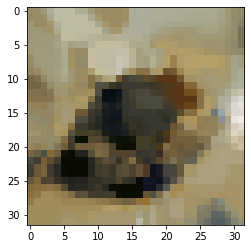

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [ ]:
from keras import models

layer_outputs = [layer.output for layer in model_best.layers[:4]]
activation_model = models.Model(inputs=model_best.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor) 

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 30, 30, 256)


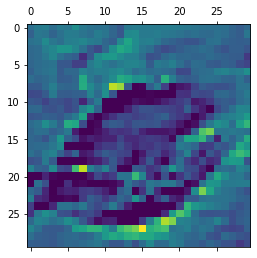

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 8], cmap='viridis')